In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd 'drive/My Drive/'

/content/drive/My Drive


In [3]:
ls 'Capstone'

 convertVideotoCSV.py               test_video_list_and_name_mapping.zip
 EvaluationScriptsAndExamples.zip   test.zip
'kaggle (1).json'                   train_color/
 kaggle.json                        train_label/
 sample_submission.csv              train_label.zip
 sample_submission.csv.zip          train_video_list.zip


In [4]:
!pip install segmentation_models

In [5]:
#Importing necessary libraries
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"  #- Uncomment this to run tensorflow on CPU
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
from glob import glob

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import segmentation_models as sm

Segmentation Models: using `keras` framework.


Using TensorFlow backend.


In [6]:
IMG_HEIGHT = 256
IMG_WIDTH = 256

IMG_DIR  = os.path.join('.', 'Capstone', 'train_color')
MASK_DIR = os.path.join('.', 'Capstone', 'train_label')

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

INPUT_SIZE = (IMG_HEIGHT, IMG_WIDTH, 3)
INPUT_MASK_SIZE = (IMG_HEIGHT, IMG_WIDTH, 1)

BATCH_SIZE = 16

IMG_DIR, MASK_DIR

('./Capstone/train_color', './Capstone/train_label')

In [7]:
img_paths  = pd.DataFrame(dict(path = glob(os.path.join(IMG_DIR, '*.*j*g'))))
mask_paths = pd.DataFrame(dict(path = glob(os.path.join(MASK_DIR, '*.*p*g'))))

all_paths = img_paths.append(mask_paths)
all_paths['group'] = all_paths['path'].map(lambda x: x.split(f'{os.sep}')[-2].split('_')[-1])
all_paths['id'] = all_paths['path'].map(lambda x: '_'.join(os.path.splitext(os.path.basename(x))[0].split('_')[0:4]))
all_paths.head()

,path,group,id
0,./Capstone/train_color/170908_061538269_Camera...,color,170908_061538269_Camera_5
1,./Capstone/train_color/170908_061538269_Camera...,color,170908_061538269_Camera_6
2,./Capstone/train_color/170908_061538547_Camera...,color,170908_061538547_Camera_6
3,./Capstone/train_color/170908_061538825_Camera...,color,170908_061538825_Camera_5
4,./Capstone/train_color/170908_061538825_Camera...,color,170908_061538825_Camera_6


In [8]:
len(img_paths), len(mask_paths)

(2000, 2000)

In [9]:
group_df = all_paths.pivot_table(values = 'path', columns = 'group', aggfunc = 'first', index = ['id']).reset_index()
group_df.head()

group,id,color,label
0,170908_061502408_Camera_5,./Capstone/train_color/170908_061502408_Camera...,./Capstone/train_label/170908_061502408_Camera...
1,170908_061502408_Camera_6,./Capstone/train_color/170908_061502408_Camera...,./Capstone/train_label/170908_061502408_Camera...
2,170908_061502547_Camera_5,./Capstone/train_color/170908_061502547_Camera...,./Capstone/train_label/170908_061502547_Camera...
3,170908_061502547_Camera_6,./Capstone/train_color/170908_061502547_Camera...,./Capstone/train_label/170908_061502547_Camera...
4,170908_061502686_Camera_5,./Capstone/train_color/170908_061502686_Camera...,./Capstone/train_label/170908_061502686_Camera...


In [10]:
group_df.columns, group_df.shape

(Index(['id', 'color', 'label'], dtype='object', name='group'), (2000, 3))

In [0]:
from sklearn.model_selection import train_test_split
train_split_df, valid_split_df = train_test_split(group_df, random_state = 2018, test_size = 0.20)

In [12]:
train_split_df.shape, valid_split_df.shape

((1600, 3), (400, 3))

In [0]:
import cv2

def data_gen(df, size=16, normalize=True):
    if size > df.shape[0]:
        print('Size is bigger than available number of images. Please specify a smaller size than ', df.shape[0])
        return
    elif size < 0:
        print('Size should be greater than zero ', df.shape[0])

    ids = df['id'].tolist()
    random.shuffle(ids)
  
    for i in range(size):
        img = np.zeros((size, IMG_HEIGHT, IMG_WIDTH, 3)).astype('float')
        mask = np.zeros((size, IMG_HEIGHT, IMG_WIDTH, 1)).astype('float')

        img_path  = df.loc[df['id'] == ids[i]]['color'].values[0]
        mask_path = df.loc[df['id'] == ids[i]]['label'].values[0]
        #print("Pair:")
        #print("\t", img_path)
        #print("\t", mask_path)

        train_img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        #train_img = train_img[:,:,0]        # Just take one frame in order to reduce memory footprint of each image. This allows to load more images in memory.
        if normalize:
            train_img = train_img/255.
        train_img =  cv2.resize(train_img, (IMG_WIDTH, IMG_HEIGHT)) # Resize
        #train_img = train_img.reshape(IMG_HEIGHT, IMG_WIDTH, 1)

        img[i] = train_img #add to array - img[0], img[1], and so on.


        train_mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        train_mask = np.where( np.logical_or(train_mask <33000, train_mask > 40000), 0, train_mask)
        #train_mask = (t_mask//1000) + ((t_mask%1000)/100)            
        train_mask = (train_mask//1000)    # Divide pixel value by 1000 and taking the integer will result in smaller value. e.g. 33001 will become 33 after this operation
        train_mask = train_mask/40         # The highest number would be 40, so dividing it by 40 will ensure each pixel value is between 0 & 1 (both inclusive)

        train_mask = cv2.resize(train_mask, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv2.INTER_NEAREST)
        train_mask = train_mask.reshape(IMG_HEIGHT, IMG_WIDTH, 1) # Add extra dimension for parity with train_img size [384 * 384 * 3]

        mask[i] = train_mask

        
        if((i+1)%500 == 0):
            random.shuffle(ids)
            print('randomizing again')
        
    return img, mask

In [14]:
X_train, y_train = data_gen(train_split_df, size=1600, normalize=True)
X_valid, y_valid = data_gen(valid_split_df, size=400, normalize=True)

randomizing again
randomizing again
randomizing again


In [15]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((1600, 256, 256, 3),
 (1600, 256, 256, 1),
 (400, 256, 256, 3),
 (400, 256, 256, 1))

In [0]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return (numerator + 1)/ (denominator + 1)

In [0]:
def dice_loss(y_true, y_pred):
  return 1 - dice_coefficient(y_true, y_pred)

In [0]:
from tensorflow.keras.losses import categorical_crossentropy
def loss(y_true, y_pred):
    return categorical_crossentropy(y_true, y_pred) - tf.math.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

In [19]:
x_train = preprocess_input(X_train)
x_valid = preprocess_input(X_valid)
#x_train = X_train
#x_valid = X_valid

model = sm.Unet(backbone_name=BACKBONE, encoder_weights='imagenet', input_shape=(None, None, 3), encoder_freeze=True)
model.summary()














Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, None, None, 3 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_1[0][0]           
_______________________________________________________________________________

In [20]:
model.compile(
    'RMSprop',
    loss=dice_loss,
    metrics=[dice_coefficient],
)

In [21]:
lr_reduce = ReduceLROnPlateau(monitor='dice_coefficient', factor=0.1, epsilon=1e-5, patience=5, verbose=1)
es = EarlyStopping(monitor='dice_coefficient', patience=50, verbose=1, mode='auto')

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [22]:
model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,    
    epochs=1000,
    validation_data=(x_valid, y_valid),
    callbacks=[lr_reduce, es]
)



Train on 1600 samples, validate on 400 samples
Epoch 1/1000
1600/1600 [==============================] - 51s 32ms/step - loss: 1.0000 - dice_coefficient: 3.6635e-06 - val_loss: 0.9999 - val_dice_coefficient: 1.0604e-04
Epoch 2/1000
1600/1600 [==============================] - 33s 21ms/step - loss: 0.9999 - dice_coefficient: 8.5863e-05 - val_loss: 0.9991 - val_dice_coefficient: 9.1126e-04
Epoch 3/1000
1600/1600 [==============================] - 33s 21ms/step - loss: 0.8300 - dice_coefficient: 0.1700 - val_loss: 0.9818 - val_dice_coefficient: 0.0182
Epoch 4/1000
1600/1600 [==============================] - 34s 21ms/step - loss: 0.0837 - dice_coefficient: 0.9163 - val_loss: 0.5155 - val_dice_coefficient: 0.4845
Epoch 5/1000
1600/1600 [==============================] - 34s 21ms/step - loss: 0.0219 - dice_coefficient: 0.9781 - val_loss: 0.1766 - val_dice_coefficient: 0.8234
Epoch 6/1000
1600/1600 [==============================] - 34s 21ms/step - loss: 0.0193 - dice_coefficient: 0.9807 -

In [23]:
preds_val = model.predict(x_valid, verbose=1)

400/400 [==============================] - 4s 9ms/step


In [24]:
preds_val.shape

(400, 256, 256, 1)

In [25]:
pred_mask = preds_val[10].reshape(IMG_HEIGHT, IMG_WIDTH)
pred_mask = pred_mask * 40 * 1000
pred_mask.shape

(256, 256)

In [26]:
pd.DataFrame(pred_mask)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255
0,0.002384,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002384
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
252,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
253,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
254,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


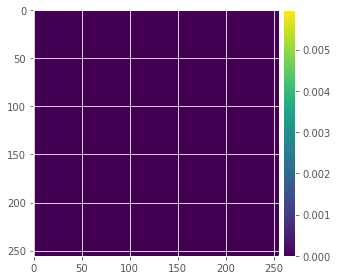

In [27]:
imshow(pred_mask)